# Batch Fairness

In this notebook we compare the fairness of the different batch algorithms and experiment with ways to improve it.

We define the fairness as the amount of samples taken from each class. For simplicity sake we will only use two classes and define the fairness as: 
$$
Fairness = \frac{amount\_of\_samples\_from\_class}{amount\_of\_total\_samples}
$$

In [1]:
#imports
import numpy as np

# matplotlib
import matplotlib as mlp
import matplotlib.pyplot as plt

# sklearn
from skactiveml.classifier import SklearnClassifier
from skactiveml.pool import UncertaintySampling, BatchBALD
from skactiveml.utils import MISSING_LABEL

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression

# balanced accuracy
from balanced_accuracy import balanced_accuracy

# plot
from plot_accuracy import plot_accuracy

# warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
def check_fairness(samples, label):
    amount = 0
    for sample in samples:
        if sample == label:
            amount += 1 
    return amount / len(samples)

In [3]:
def al_batch_fairness(iterations=10, batch_size=5, weights = [0.8, 0.2], data_size=400, query_count=10):
    data = []
    data2 = []
    qs = UncertaintySampling(method='entropy')
    for rand in range(iterations):
        # Create the data
        X, y = make_classification(n_samples=data_size, n_features=2, n_redundant=0, weights=weights, random_state=rand)
        Xf, Xt, yf, yt = train_test_split(X, y, random_state=rand)
        y = np.full(shape=yf.shape, fill_value=MISSING_LABEL)
        
        clf = SklearnClassifier(LogisticRegression(), classes=np.unique(yf))
        clf.fit(Xf, y)
        out = []
        out2 = []
        for _ in range(query_count):
            query_idx = qs.query(Xf, y, clf=clf, batch_size=batch_size)
            y[query_idx] = yf[query_idx]
            clf.fit(Xf, y)
            prediction = clf.predict(Xt)
            
            out.append(check_fairness(yf[query_idx], 1))
            out2.append(balanced_accuracy(yt, prediction))
        data.append(out)
        data2.append(out2)
    return (np.mean(np.array(data), axis=0), np.mean(np.array(data2), axis=0))

def al_bald_fairness(iterations=100, batch_size=5, weights = [0.8, 0.2], data_size=400, query_count=10):
    data = []
    data2 = []
    qs = BatchBALD()
    for rand in range(iterations):
        # Create the data
        X, y = make_classification(n_samples=data_size, n_features=2, n_redundant=0, weights=weights, random_state=rand)
        Xf, Xt, yf, yt = train_test_split(X, y, random_state=rand)
        y = np.full(shape=yf.shape, fill_value=MISSING_LABEL)
        ensemble = []
        ensemble.append(SklearnClassifier(LogisticRegression(), classes=np.unique(yf)))
        for clf in ensemble:
            clf.fit(Xf, y)
        out = []
        out2 = []
        for _ in range(query_count):
            query_idx = qs.query(Xf, y, ensemble=ensemble, batch_size=batch_size)
            y[query_idx] = yf[query_idx]
            
            accumulated_acc = 0
            for clf in ensemble:
                clf.fit(Xf, y)
                prediction = clf.predict(Xt)
                accumulated_acc += balanced_accuracy(yt, prediction)
            out.append(check_fairness(yf[query_idx], 1))
            out2.append(accumulated_acc/len(ensemble))
        data.append(out)
        data2.append(out2)
    return (np.mean(np.array(data), axis=0), np.mean(np.array(data2), axis=0))

In [4]:
batch_fairnesses, batch_accuracies = al_batch_fairness()

In [5]:
bald_fairnesses, bald_accuracies = al_bald_fairness()

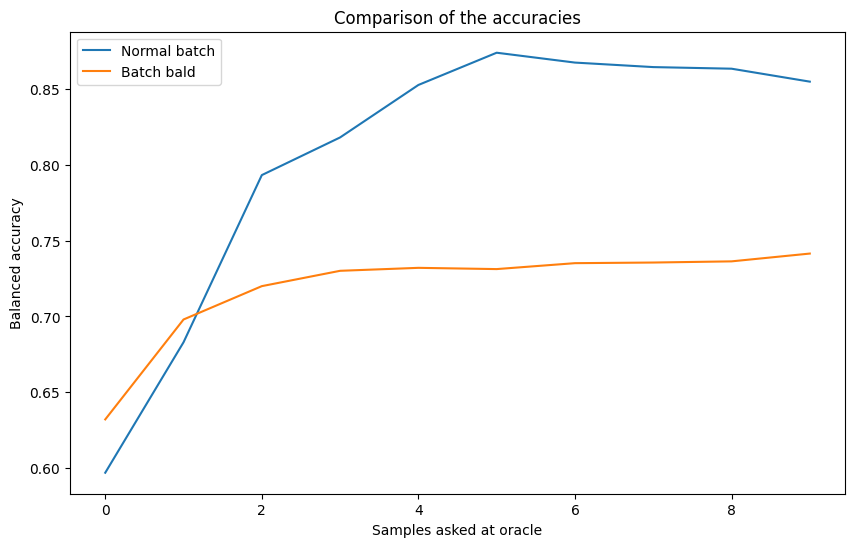

In [6]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))

plot_accuracy('Comparison of the accuracies', [[batch_accuracies, "Normal batch"], 
                                               [bald_accuracies, "Batch bald"]], axs)

fig.show()

In [7]:
print(f'Normal batch fairness: {np.mean(batch_fairnesses)}')
print(f'Batch bald fairness: {np.mean(bald_fairnesses)}')

Normal batch fairness: 0.4780000000000001
Batch bald fairness: 0.2053999999999999


These scores seem to align with the performance of the models, meaning that if a model is more fair it would perform better. We want the scores to near 50% which is the best with normal batches.